# General/Comprehensive Preprocessing For LDA, NMF, and LSA

## Dependencies

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import re
import spacy
import gensim.models.phrases as phrases
from nltk.corpus import stopwords
import nltk
import emoji
import contractions
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.tokenizer import SocialTokenizer
import datetime
import pandas as pd

## Preparation

In [5]:
df = pd.read_csv('../data/raw/merged_tweets_en.csv')

nltk_data_path = "../data/libs/nltk_data"
nltk.data.path.append(nltk_data_path)
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
nlp.add_pipe("sentencizer")

## POS Frequency Visualization

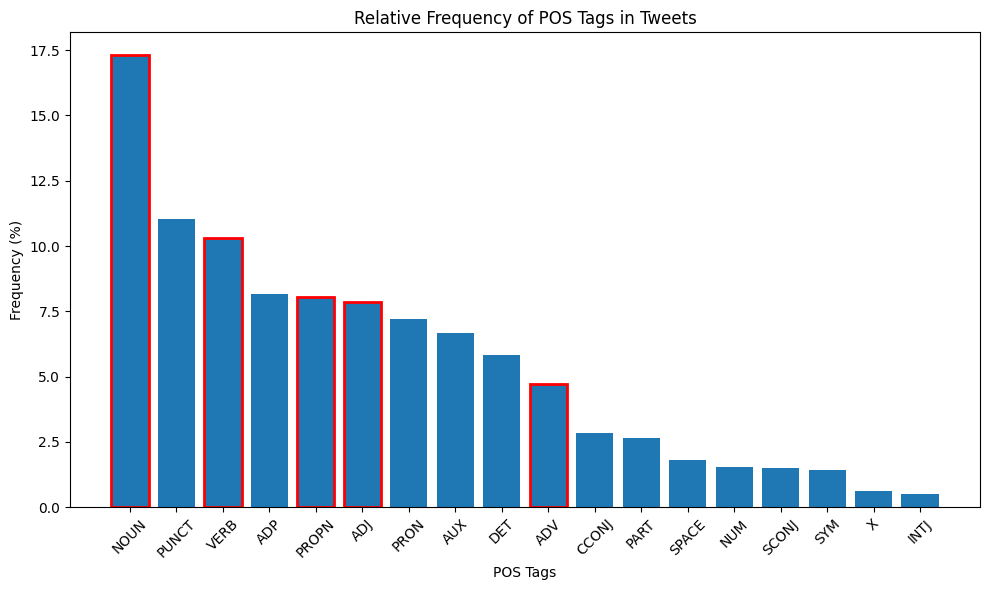

In [8]:
# Count all POS tags
pos_counts = Counter()
for doc in nlp.pipe(df['content'].astype(str), batch_size=50, disable=["ner", "parser"]):
    for token in doc:
        pos_counts[token.pos_] += 1

# Calculate relative frequencies
total = sum(pos_counts.values())
pos_freq = {pos: count / total * 100 for pos, count in pos_counts.items()}
sorted_freq = dict(sorted(pos_freq.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(sorted_freq.keys(), sorted_freq.values())

# Highlight selected POS
highlighted = ["NOUN", "VERB", "ADJ", "ADV", "PROPN"]
for bar, label in zip(bars, sorted_freq.keys()):
    if label in highlighted:
        bar.set_edgecolor('red')
        bar.set_linewidth(2)

plt.title("Relative Frequency of POS Tags in Tweets")
plt.xlabel("POS Tags")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing

### Ekpharsis Config

In [ ]:
text_processor = TextPreProcessor(
    annotate={},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer().tokenize,
    dicts=[emoticons]
)

### Custom Stopwords

In [ ]:
stop_words = set(stopwords.words("english"))

custom_stopwords = {
    "actually", "ago", "agree", "also", "answer", "anyone", "around", "article", "ask", "away", "back", "bad", "bit", "could", "come", "covid", "covid-19", "covid_19", "day", "damn", "disagree", "due", "else", "ever", "everyone", "example", "finally", "find", "follow", "fuck", "get", "give", "go", "good", "hah", "haha", "happen", "hear", "hell", "info", "join", "kinda", "kind", "know", "later", "leave", "less", "link", "live", "lol", "lolol", "long", "long-covid", "long_covid", "longcovid", "look", "lot", "make", "many", "may", "maybe", "much", "must", "need", "never", "new", "next", "news", "omg", "one", "ones", "people",  "ppl", "please", "post", "probably", "pretty", "quite", "read", "really", "right", "say", "see", "share", "shit", "show", "speak", "sorry", "sort", "sort-of", "still", "suck", "sure", "take", "talk", "tell", "thank", "thank-you", "thanks", "think", "thing", "time", "today", "try", "tweet", "twitter", "type", "uh", "uh-huh", "um", "update", "use", "vid", "via", "want", "way", "well", "would", "wrong", "yeah", "yep","even" ,"keep", "yet", "thread", "story", "watch", "listen", "write", "video", "comment", "piece", "start", "stop", "let", "put", "become", "seem", "great", "amazing", "interesting", "clear", "big", "huge", "point", "amp", "rt"
}

stop_words.update(custom_stopwords)

### Util Functions for Cleaning

In [ ]:
def expand_abbreviations(text):
    return " ".join(text_processor.pre_process_doc(text))

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def expand_contractions(text):
    return contractions.fix(text)

def fix_spacing_issues(text):
    return re.sub(r'(\w)([A-Z])', r'\1 \2', text)

def sentence_segmentation(text):
    doc = nlp(text)
    return " ".join([sent.text for sent in doc.sents])

def remove_duplicate_words(text):
    words = text.split()
    return " ".join(sorted(set(words), key=words.index))

def remove_short_words(text, min_len=3):
    return " ".join([word for word in text.split() if len(word) >= min_len])

### Preprocess Function

In [ ]:
def preprocess(text):
    text = clean_text(text)
    tokens = [
        token.lemma_ for token in nlp(text)
        if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV", "PROPN"]
        and token.lemma_ not in stop_words
    ]
    return tokens if len(tokens) > 1 else ""

### Bigram Trigram Functions

In [ ]:
def build_bigrams_trigrams(processed_tweets):
    bigram = phrases.Phrases(processed_tweets, min_count=50, threshold=50)
    trigram = phrases.Phrases(bigram[processed_tweets], threshold=50)

    bigram_mod = phrases.Phraser(bigram)
    trigram_mod = phrases.Phraser(trigram)

    return [trigram_mod[bigram_mod[doc]] for doc in processed_tweets]

### Main Cleaning Function

In [ ]:
def clean_text(text):
    text = text.lower()
    text = expand_abbreviations(text)
    text = remove_emojis(text)
    text = fix_spacing_issues(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|\#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = sentence_segmentation(text)
    text = remove_duplicate_words(text)
    text = remove_short_words(text, min_len=3)
    return text

## Comprehensive Cleaning Script

In [7]:
print(f"Initial rows: {len(df)}")

# Sample for testing
# df = df.head(200)
print(f"After sampling: {len(df)}")

# Keep relevant columns
df_cleaned = df[["date", "content"]]
print(f"After column filtering: {len(df_cleaned)}")

# Drop missing content
df_cleaned = df_cleaned.dropna(subset=["content"])
print(f"After dropping missing content: {len(df_cleaned)}")

# Drop duplicates based on content
df_cleaned = df_cleaned.drop_duplicates(subset=["content"])
print(f"After dropping duplicates: {len(df_cleaned)}")

# Apply text preprocessing → bigrams/trigrams → stopword removal → join
processed_tweets = df_cleaned["content"].apply(preprocess)
processed_tweets = build_bigrams_trigrams(processed_tweets.tolist())
processed_tweets = [[token for token in tweet if token not in stop_words] for tweet in processed_tweets]
final_texts = [" ".join(tweet) for tweet in processed_tweets]

# Add final text column only
df_cleaned["final_text"] = final_texts
print(f"After final stopword cleanup: {len(df_cleaned)}")

# Drop missing/blank final_text rows
df_cleaned = df_cleaned.dropna(subset=["final_text"])
df_cleaned = df_cleaned[df_cleaned["final_text"].str.strip().astype(bool)]
print(f"After cleaning empty/blank final_text rows: {len(df_cleaned)}")

# Save clean data
date_today = datetime.datetime.today().strftime("%Y%m%d_%H%M")
df_cleaned.to_csv(f"../data/processed/{date_today}_clean_merged_tweets.csv", index=False)

# Show preview
df_cleaned.head()

Initial rows: 499123
After sampling: 499123
After column filtering: 499123
After dropping missing content: 499123
After dropping duplicates: 497007
After final stopword cleanup: 497007
After cleaning empty/blank final_text rows: 472051


,date,content,final_text
0,2022-04-29 23:59:28+00:00,"@KunstJonas ""Singing lullabies like 'Twinkle T...",singe lullaby twinkle little star help bed res...
1,2022-04-29 23:58:50+00:00,"Useful, but one of the problems with Long COVI...",useful problem classification separate term da...
3,2022-04-29 23:58:22+00:00,@NSWHealth Dr Moy ( VP AMA)- C19 not done with...,moy ama aust head herd_immunity variant curren...
4,2022-04-29 23:57:56+00:00,@MandateMasksNY @GovKathyHochul @DrMaryTBasset...,case fingerlake region last week mask fun end ...
5,2022-04-29 23:57:28+00:00,@Taylor9_7 @DailyJLee Actually yes that happen...,work help pass stand
